In [1]:


import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import glob
import os
import csv
from scipy.stats import f_oneway
from scipy.stats import shapiro, levene, probplot
import math
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats
import sys
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import kruskal
from itertools import combinations
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns  # fine in your own env

#conversion factors
in_to_m = 0.0254

def load_tensile_csv(csv_path):
    """
    Loads tensile raw data CSVs that may contain:
      - metadata header lines
      - mixed delimiters
      - inconsistent column counts
    Returns a cleaned DataFrame with numeric columns only.
    """

    # First: Detect delimiter
    with open(csv_path, "r") as f:
        sample = f.read(2048)

    try:
        sniffer = csv.Sniffer()
        dialect = sniffer.sniff(sample, delimiters=[',',';','\t',' '])
        delimiter = dialect.delimiter
    except:
        delimiter = ','  # fallback

    # Second: Read the file while skipping bad rows
    df = pd.read_csv(
        csv_path,
        sep=delimiter,
        engine="python",
        comment='#',
        skiprows=5,
        #on_bad_lines='skip',    # <-- prevents crash
        skip_blank_lines=True
    )

    # Third: Drop EMPTY or non-numeric columns
    for col in df.columns:
        try:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        except:
            df[col] = pd.NA

    df = df.dropna(axis=1, how='all')  # remove columns with no data
    df = df.dropna(axis=0, how='any')  # remove unfinished rows

    print(df)
    return df

def compute_youngs_modulus(
    csv_path,
    gauge_length,
    cross_section_area,
    load_col='Load',
    disp_col='Extension',
    elastic_strain_max=0.005
):
    """
    Computes Young's modulus from tensile test data.

    Parameters
    ----------
    csv_path : str
        Path to CSV file containing load/displacement data.
    gauge_length : float
        Original specimen length (m).
    cross_section_area : float
        Cross-sectional area (m^2).
    load_col : str
        Column name for load/force.
    disp_col : str
        Column name for displacement/extension.
    elastic_strain_max : float
        Maximum strain to use for the linear elastic fit (default = 0.5%).

    Returns
    -------
    E : float
        Estimated Young’s modulus (Pa).
    stress : ndarray
    strain : ndarray
        Arrays of engineering stress and strain.
    """
    # print(f"gauge_length {gauge_length}")
    # print(f"x_area {cross_section_area}")

    # Load file
    df = load_tensile_csv(csv_path)

    # Extract data
    force = df[load_col].values
    disp  = df[disp_col].values

    # print(f"disp {disp}")

    # Engineering strain
    strain = disp / gauge_length

    # Engineering stress
    stress = force / cross_section_area

    # Select elastic region
    mask = strain <= elastic_strain_max
    strain_elastic = strain[mask].reshape(-1, 1)
    stress_elastic = stress[mask]

    # Linear regression (slope = E)
    # model = LinearRegression().fit(strain_elastic, stress_elastic)
    # E = model.coef_[0]
    E = 0

    return E, stress, strain


In [2]:
def ultimate_tensile_strength(stress):
    """
    Maximum stress achieved in the test.
    """
    return np.max(stress)

def offset_yield_strength(E, strain, stress, offset=0.02):
    """
    Computes the offset yield strength (default 2%).
    Uses interpolation to find intersection of stress-strain curve with
    offset line of slope equal to the elastic modulus.
    """
    offset_line = E*(strain - offset)

    # difference between actual curve and offset line
    diff = stress - offset_line
    
    # find zero crossing
    idx = np.where(np.diff(np.sign(diff)))[0]
    if len(idx) == 0:
        return None  # No yield point found
    
    i = idx[0]
    # linear interpolation for better accuracy
    x1, x2 = strain[i], strain[i+1]
    y1, y2 = diff[i], diff[i+1]
    
    strain_yield = x1 - y1*(x2 - x1)/(y2 - y1)
    stress_yield = np.interp(strain_yield, strain, stress)
    
    return stress_yield

def total_energy(strain, stress):
    """
    Integrates the stress-strain curve using the trapezoidal rule.
    Units depend on stress/strain units (e.g., MPa -> MJ/m^3).
    """
    return np.trapezoid(stress, strain)

def strain_at_fracture(strain):
    """
    Maximum strain recorded before failure.
    """
    return np.max(strain)

In [3]:
def analyze_tensile_folder(folder_path, gauge_length_list, cross_section_area_list, mass_list, stress_func, strain_func):
    """
    Processes all CSV tensile data files in a folder and returns a summary table.
    """

    results = []

    csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
    # print(csv_files)

    for csv_path in csv_files:
        try:

            sample_index = int(os.path.basename(csv_path).split("_")[2][0])-1
            # print(sample_index)
            # --- Stress & strain + Young's modulus ---
            E, stress_raw, strain_raw = compute_youngs_modulus(
                csv_path,
                gauge_length_list[sample_index],
                cross_section_area_list[sample_index]
            )
            # print("fail 1")


            stress = [stress_func(val) for val in stress_raw]
            strain = [strain_func(val) for val in strain_raw]

            # print(f"raw strain {strain_raw}")
            # print(f"raw stress {stress_raw}")

            # print(f" strain {strain}")
            # print(f" stress {stress}")

            # print(csv_path)
            
            # sys.exit()
            # --- Individual metrics ---
            uts = ultimate_tensile_strength(stress)
            # print("fail1.5")
            #ys  = offset_yield_strength(strain, stress, E)
            # print("fail1.5")
            energy = total_energy(strain, stress)
            # print("fail1.5")

            eps_f = strain_at_fracture(strain)
            # print("fail 2")
            results.append({
                "Filename": os.path.basename(csv_path),
                "Youngs_Modulus_Pa": E,
                "UTS_Pa": uts,
            #    "YieldStrength_2pct_Pa": ys,
                "TotalEnergy_Jperm3": energy,
                "StrainAtFracture": eps_f,
                "UTS_Pa_per_Mass_kg": uts/(mass_list[sample_index]/1000) 
            })

            # print(results, uts, energy, eps_f)

        except Exception as e:
            print(f"Error processing {csv_path}: {e}")

    return pd.DataFrame(results)


In [4]:
#Helper - After Sinter Part Dimensino Dictionary
after_print_dim = pd.read_csv("after_sinter_dimensions_2.csv")
all_combinations = ["Gyroid_8", "Gyroid_6", "Gyroid_4", "Solid_8", "Solid_6", "Solid_4", "Triangular_8", "Triangular_6", "Triangular_4"]

measurement_types = ["length (in)", "thickness (in)", "width (in)", "mass (g)"]

combo_to_measurement = {}
for combination in all_combinations:
    sub_df = after_print_dim[(after_print_dim["infill_type"] == combination.split("_")[0].lower()) & (after_print_dim["wall_thickness"] == float(combination.split("_")[1]))]
    
    #extracts the array STRINGS
    len_s = sub_df[sub_df["measurement"] == measurement_types[0]]["part_means"].values[0]
    thic_s = sub_df[sub_df["measurement"] == measurement_types[1]]["part_means"].values[0]
    width_s = sub_df[sub_df["measurement"] == measurement_types[2]]["part_means"].values[0]
    mass_s = sub_df[sub_df["measurement"] == measurement_types[3]]["part_means"].values[0]

    #converts array strings to array
    len_arr = np.array([float(x)*in_to_m for x in len_s.strip("[]").split()])
    thic_arr = np.array([float(x)*in_to_m for x in thic_s.strip("[]").split()])
    width_arr = np.array([float(x)*in_to_m for x in width_s.strip("[]").split()])
    mass_arr = np.array([float(x) for x in mass_s.strip("[]").split()])


    combo_to_measurement[combination] = [len_arr, thic_arr*width_arr,mass_arr]

print(combo_to_measurement)
#each entry --> combinatino
#within each entry [list of average length means for each sample], [list of average cross sectional area for each sample], [list of average masses for each sample]

{'Gyroid_8': [array([0.11042142, 0.11042142, 0.1103884 , 0.1104265 ]), array([2.17018918e-05, 2.18103647e-05, 2.17774185e-05, 2.18388383e-05]), array([17.52 , 17.514, 17.51 , 17.51 ])], 'Gyroid_6': [array([0.11066018, 0.11053064, 0.11057382, 0.11054588]), array([2.17503863e-05, 2.18874081e-05, 2.19652786e-05, 2.20334398e-05]), array([16.04, 16.04, 16.04, 16.04])], 'Gyroid_4': [array([0.11077194, 0.11087354, 0.1106932 , 0.11063478]), array([2.17694621e-05, 2.19991495e-05, 2.22288692e-05, 2.18847516e-05]), array([14.73, 14.73, 14.73, 14.73])], 'Solid_8': [array([0.11142726, 0.11144758, 0.11146282, 0.1114806 ]), array([2.18838272e-05, 2.16172683e-05, 2.16206237e-05, 2.19557838e-05]), array([22.69, 22.69, 22.69, 22.68])], 'Solid_6': [array([0.11143996, 0.11147044, 0.11147552, 0.1114298 ]), array([2.18221066e-05, 2.15389569e-05, 2.15593658e-05, 2.15899568e-05]), array([22.55, 22.55, 22.55, 22.63])], 'Solid_4': [array([0.11146282, 0.11141202, 0.11142472, 0.1114298 ]), array([2.12045382e-05, 

In [5]:
#Helper - Measurement and Tensile Calibration

# ---------- helper: generic linear calibration fit ----------
def fit_linear_calibration(x_measured, y_true):
    """
    Fits y_true = a * x_measured + b  via least squares.
    Returns (a, b).
    """
    x = np.asarray(x_measured, dtype=float)
    y = np.asarray(y_true, dtype=float)
    a, b = np.polyfit(x, y, 1)
    return a, b

# ---------- 1. Displacement calibration ----------
disp_df = pd.read_csv("Calibration_Filtererd_Data/displacement_calibration.csv")

a_disp, b_disp = fit_linear_calibration(
    disp_df["instron_extension_in"],
    disp_df["true_extension_in"]
)

print(f"Displacement calibration:")
print(f"  x_true = {a_disp:.6f} * x_instron + {b_disp:.6f}")

def calibrate_displacement(x_instron):
    """Apply displacement calibration to a NumPy array / Series / scalar."""
    return a_disp * x_instron + b_disp


# ---------- 2. Load calibration ----------
load_df = pd.read_csv("Calibration_Filtererd_Data/load_calibration.csv")

# Drop any rows where instron_load_lbf is still empty
load_df = load_df.dropna(subset=["instron_load_lbf"])

a_load, b_load = fit_linear_calibration(
    load_df["instron_load_lbf"],
    load_df["true_load_lbf"]
)

print(f"\nLoad calibration:")
print(f"  F_true = {a_load:.6f} * F_instron + {b_load:.6f}")

def calibrate_load(F_instron):
    """Apply load calibration to a NumPy array / Series / scalar."""
    return a_load * F_instron + b_load



Displacement calibration:
  x_true = 0.998695 * x_instron + 0.000012

Load calibration:
  F_true = 1.007285 * F_instron + 1.150238


In [6]:
#some helper dataframe methods
def parse_geometry_level(folder_name):
    base = folder_name.split("/")[-1]                 # e.g. Gyroid_4.is_tens_RawData
    base = base.replace(".is_tens_RawData", "")       # Gyroid_4
    geom, level = base.split("_")
    return geom, int(level)

def build_two_way_df(results_by_condition, metric_col):
    rows = []
    for folder_name, df in results_by_condition.items():
        geom, level = parse_geometry_level(folder_name)
        for val in df[metric_col].dropna():
            rows.append({
                "geometry": geom,
                "level": level,
                metric_col: val
            })
    return pd.DataFrame(rows)

def build_oneway_df(results_by_condition, metric_col):
    """
    results_by_condition: dict[name -> DataFrame]
                          (e.g. from analyze_tensile_folder)
    metric_col: string, e.g. "UTS_Pa"
    """
    rows = []
    for condition_name, df in results_by_condition.items():
        for val in df[metric_col].dropna():
            rows.append({
                "condition": condition_name,
                metric_col: float(val),
            })
    return pd.DataFrame(rows)

       Time  Extension         Load
1     0.000   -0.05554     28.41016
2     0.100   -0.04626     29.58838
3     0.200   -0.02779    139.16315
4     0.300   -0.00887    347.17056
5     0.400    0.00925    538.11029
..      ...        ...          ...
231  22.586    3.70913  13296.40918
232  22.588    3.70951  12381.66895
233  22.590    3.70989  11433.76562
234  22.592    3.71026  10478.14355
235  22.594    3.71064   9530.74902

[235 rows x 3 columns]
       Time  Extension         Load
1     0.000   -0.05284      0.70008
2     0.100   -0.04354      1.04164
3     0.200   -0.02495    138.66011
4     0.300   -0.00602    350.92212
5     0.400    0.01202    541.62836
..      ...        ...          ...
227  22.154    3.63994  13565.58496
228  22.156    3.64031  12672.35742
229  22.158    3.64067  11739.90625
230  22.160    3.64104  10790.37891
231  22.162    3.64142   9840.77637

[231 rows x 3 columns]
       Time  Extension         Load
1     0.000   -0.04909      6.39622
2     0.100   -0

/Users/ericyang/Documents/GitHub/ME103_Data_Processing/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '


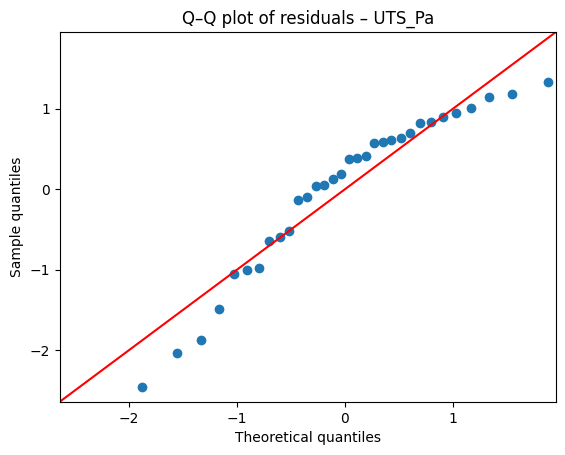

Levene’s test across cells: stat=0.5433, p=0.7932
                  Multiple Comparison of Means - Tukey HSD, FWER=0.05                  
   group1       group2        meandiff    p-adj       lower           upper      reject
---------------------------------------------------------------------------------------
    Gyroid_4     Gyroid_6  124737394.1887    0.0   106186808.736  143287979.6414   True
    Gyroid_4      Solid_4  548482072.8125    0.0  529931487.3598  567032658.2652   True
    Gyroid_4      Solid_6  539755286.8785    0.0  521204701.4258  558305872.3312   True
    Gyroid_4      Solid_8  532835016.7265    0.0  514284431.2738  551385602.1792   True
    Gyroid_4 Triangular_4     3797573.429 0.9969  -14753012.0237   22348158.8816  False
    Gyroid_4 Triangular_6    104167063.53    0.0   85616478.0773  122717648.9827   True
    Gyroid_4 Triangular_8  205666211.6484    0.0  187115626.1957  224216797.1011   True
    Gyroid_6      Solid_4  423744678.6238    0.0  405194093.1711  4422

/Users/ericyang/Documents/GitHub/ME103_Data_Processing/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '


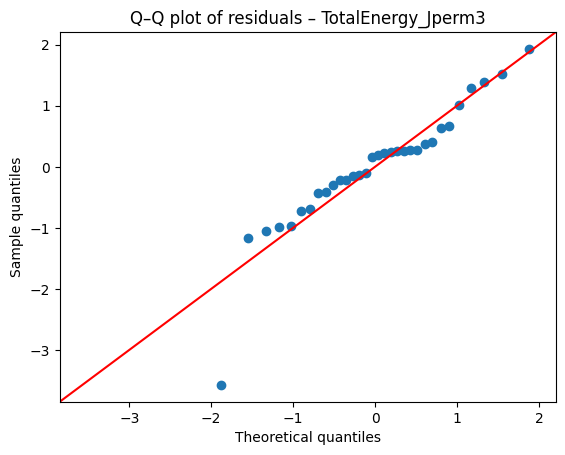

Levene’s test across cells: stat=1.2562, p=0.3127
                      Multiple Comparison of Means - Tukey HSD, FWER=0.05                      
   group1       group2         meandiff      p-adj        lower              upper       reject
-----------------------------------------------------------------------------------------------
    Gyroid_4     Gyroid_6   17337879041.8194    0.0    8160429013.4074  26515329070.2313   True
    Gyroid_4      Solid_4   87401108271.8122    0.0   78223658243.4003  96578558300.2242   True
    Gyroid_4      Solid_6   89304988052.3138    0.0   80127538023.9018  98482438080.7257   True
    Gyroid_4      Solid_8   88581400324.7076    0.0   79403950296.2957  97758850353.1196   True
    Gyroid_4 Triangular_4  -10771756662.4228 0.0137  -19949206690.8348  -1594306634.0109   True
    Gyroid_4 Triangular_6    -969405977.2885    1.0  -10146856005.7004   8208044051.1235  False
    Gyroid_4 Triangular_8    8455993565.3729 0.0864     -721456463.039  17633443593.78

/Users/ericyang/Documents/GitHub/ME103_Data_Processing/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '


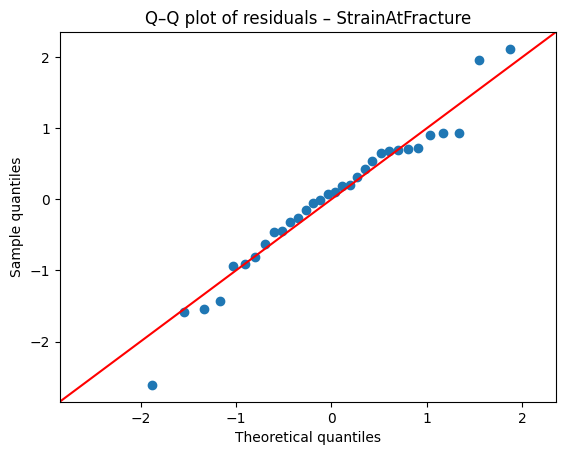

Levene’s test across cells: stat=1.0098, p=0.4491
       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
   group1       group2    meandiff p-adj   lower    upper   reject
------------------------------------------------------------------
    Gyroid_4     Gyroid_6   17.951 0.0122   2.8433  33.0586   True
    Gyroid_4      Solid_4  56.9384    0.0  41.8307   72.046   True
    Gyroid_4      Solid_6  55.1386    0.0  40.0309  70.2462   True
    Gyroid_4      Solid_8  56.4965    0.0  41.3888  71.6042   True
    Gyroid_4 Triangular_4 -27.5061 0.0001 -42.6137 -12.3984   True
    Gyroid_4 Triangular_6 -16.2896 0.0282 -31.3972  -1.1819   True
    Gyroid_4 Triangular_8  -7.8928 0.6689 -23.0005   7.2149  False
    Gyroid_6      Solid_4  38.9874    0.0  23.8797  54.0951   True
    Gyroid_6      Solid_6  37.1876    0.0    22.08  52.2953   True
    Gyroid_6      Solid_8  38.5456    0.0  23.4379  53.6532   True
    Gyroid_6 Triangular_4  -45.457    0.0 -60.5647 -30.3493   True
    Gyroid_6

/Users/ericyang/Documents/GitHub/ME103_Data_Processing/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '


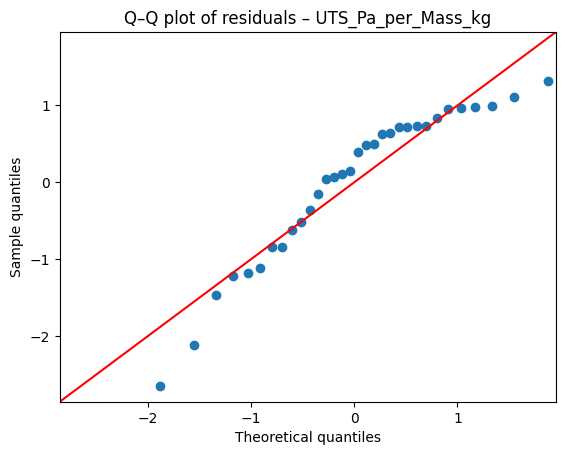

Levene’s test across cells: stat=0.3423, p=0.9261
                    Multiple Comparison of Means - Tukey HSD, FWER=0.05                    
   group1       group2        meandiff     p-adj        lower            upper       reject
-------------------------------------------------------------------------------------------
    Gyroid_4     Gyroid_6  4223088760.2305    0.0   3255896930.3704  5190280590.0907   True
    Gyroid_4      Solid_4  9086012323.7221    0.0   8118820493.8619 10053204153.5822   True
    Gyroid_4      Solid_6  8800639730.4664    0.0   7833447900.6062  9767831560.3265   True
    Gyroid_4      Solid_8  8224674999.6829    0.0   7257483169.8228  9191866829.5431   True
    Gyroid_4 Triangular_4  -212728615.0315 0.9951  -1179920444.8917   754463214.8286  False
    Gyroid_4 Triangular_6  2171681002.8214    0.0   1204489172.9613  3138872832.6815   True
    Gyroid_4 Triangular_8  4934468187.6974    0.0   3967276357.8373  5901660017.5575   True
    Gyroid_6      Solid_4  486

In [7]:
#Goal 1 - Two Way ANOVA

#get relevant folers
# folder_names = ["Gyroid_8", "Gyroid_6", "Gyroid_4", "Solid_8", "Solid_6", "Solid_4", "Triangular_8", "Triangular_6", "Triangular_4"]
folder_names = [ "Gyroid_6", "Gyroid_4", "Solid_8", "Solid_6", "Solid_4", "Triangular_8", "Triangular_6", "Triangular_4"]
folder_addendum = ".is_tens_RawData"
parent_dir = "3DPrint"
folder_names_final = [os.path.join(parent_dir, name + folder_addendum) for name in folder_names]

#define lengths and section areas
L = 1*in_to_m #in
A = 0.125*0.25*in_to_m**2 #in^2

#
actual_length = 4.349*in_to_m
actual_area = (0.125*0.25)*in_to_m**2

#getting all the references
results_by_condition = {}

for i, folder_name in enumerate(folder_names_final):
    # print(f"dict {combo_to_measurement[folder_names[i]]}")

    reference_tests = analyze_tensile_folder(
        folder_name,
        combo_to_measurement[folder_names[i]][0]/actual_length*L, combo_to_measurement[folder_names[i]][1]/actual_area*A, combo_to_measurement[folder_names[i]][2],
        calibrate_load, calibrate_displacement
    )

    results_by_condition[folder_name] = reference_tests

#define metrics
metrics = [
    "UTS_Pa",              # ultimate tensile strength
    "TotalEnergy_Jperm3",  # energy absorbed
    "StrainAtFracture",     # elongation at break
    "UTS_Pa_per_Mass_kg",  #ultimate tensile strength (pa) divided by mass of peice (in kg)
]

#ANOVA
for metric in metrics:
    df_long = build_two_way_df(results_by_condition, metric)
    print(df_long)

    model = smf.ols(f"{metric} ~ C(geometry) * C(level)", data=df_long).fit()
    print(f"\n=== 2-way ANOVA for {metric} ===")
    print(sm.stats.anova_lm(model, typ=2))

    #reisduals
    # residuals = model.resid
    resid = np.asarray(model.resid).ravel()

    # Shapiro–Wilk on residuals
    W, p = shapiro(resid)
    print(f"Shapiro–Wilk on residuals: W={W:.4f}, p={p:.4f}")

    # Q–Q plot of residuals
    resid_std = (resid - resid.mean()) / resid.std(ddof=1)

    idx = np.argmin(resid_std)

    print("Worst residual index:", idx)
    print("Standardized residual:", resid_std[idx])
    print("Row info:")
    print(df_long.iloc[idx])

    sm.qqplot(resid_std, dist=stats.norm, line="45")
    plt.title(f"Q–Q plot of residuals – {metric}")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Sample quantiles")
    plt.show()

    groups = df_long.groupby(["geometry", "level"])[metric].apply(list)
    stat, p = levene(*groups)
    print(f"Levene’s test across cells: stat={stat:.4f}, p={p:.4f}")


    #Tukey HSD
    df_long["combo"] = df_long["geometry"] + "_" + df_long["level"].astype(str)

    tukey = pairwise_tukeyhsd(
        endog=df_long[metric],       # e.g. TotalEnergy_Jperm3 values
        groups=df_long["combo"],     # Gyroid_4, Gyroid_6, ...
        alpha=0.05
    )

    print(tukey.summary())



In [8]:
#Goal 1 - Aligned Rank Transform ANOVA
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri, Formula
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.packages import importr


base   = importr("base")
stats_r  = importr("stats")
ARTool = importr("ARTool")
art_con = ARTool.art_con

#get relevant folers
# folder_names = ["Gyroid_8", "Gyroid_6", "Gyroid_4", "Solid_8", "Solid_6", "Solid_4", "Triangular_8", "Triangular_6", "Triangular_4"]
folder_names = [ "Gyroid_6", "Gyroid_4", "Solid_6", "Solid_4", "Triangular_6", "Triangular_4"]
folder_addendum = ".is_tens_RawData"
parent_dir = "3DPrint"
folder_names_final = [os.path.join(parent_dir, name + folder_addendum) for name in folder_names]

#define lengths and section areas
L = 1*in_to_m #in
A = 0.125*0.25*in_to_m**2 #in^2

#
actual_length = 4.349*in_to_m
actual_area = (0.125*0.25)*in_to_m**2

#getting all the references
results_by_condition = {}

for i, folder_name in enumerate(folder_names_final):
    # print(f"dict {combo_to_measurement[folder_names[i]]}")

    reference_tests = analyze_tensile_folder(
        folder_name,
        combo_to_measurement[folder_names[i]][0]/actual_length*L, combo_to_measurement[folder_names[i]][1]/actual_area*A, combo_to_measurement[folder_names[i]][2],
        calibrate_load, calibrate_displacement
    )

    results_by_condition[folder_name] = reference_tests

#define metrics
metrics = [
    "UTS_Pa",              # ultimate tensile strength
    "TotalEnergy_Jperm3",  # energy absorbed
    "StrainAtFracture",     # elongation at break
    "UTS_Pa_per_Mass_kg",  #ultimate tensile strength (pa) divided by mass of peice (in kg)
]

#ANOVA
for metric in metrics:
    print(f"\n================ {metric} ================")
    df_long = build_two_way_df(results_by_condition, metric)

    # Make sure geometry and level are strings (R will factor them)
    df_long["geometry"] = df_long["geometry"].astype(str)
    df_long["level"]    = df_long["level"].astype(str)

    # Convert pandas DataFrame -> R data.frame using localconverter
    with localconverter(ro.default_converter + pandas2ri.converter):
        r_df = ro.conversion.py2rpy(df_long)

    # Put into R global env
    ro.globalenv["df"] = r_df

    # Ensure factors on R side (optional but nice)
    ro.r("df$geometry <- factor(df$geometry)")
    ro.r("df$level    <- factor(df$level)")

    # Build R formula like: UTS_Pa ~ geometry * level
    f = Formula(f"{metric} ~ geometry * level")

    # Fit ART model
    m = ARTool.art(f, data=ro.globalenv["df"])

    # ANOVA on the ART model
    anova_res = stats_r.anova(m)
    print("=== ART ANOVA results ===")
    print(anova_res)

    # Post-hoc for geometry
    print("\n=== ART post-hoc for geometry ===")
    geom_con = art_con(m, "geometry")
    print(geom_con)

    # Post-hoc for level
    print("\n=== ART post-hoc for level ===")
    level_con = art_con(m, "level")
    print(level_con)

    # Post-hoc for interaction
    print("\n=== ART post-hoc for geometry:level ===")
    inter_con = art_con(m, "geometry:level")
    print(inter_con)

R callback write-console: NOTE: Results may be misleading due to involvement in interactions
  
R callback write-console: NOTE: Results may be misleading due to involvement in interactions
  


       Time  Extension         Load
1     0.000   -0.05554     28.41016
2     0.100   -0.04626     29.58838
3     0.200   -0.02779    139.16315
4     0.300   -0.00887    347.17056
5     0.400    0.00925    538.11029
..      ...        ...          ...
231  22.586    3.70913  13296.40918
232  22.588    3.70951  12381.66895
233  22.590    3.70989  11433.76562
234  22.592    3.71026  10478.14355
235  22.594    3.71064   9530.74902

[235 rows x 3 columns]
       Time  Extension         Load
1     0.000   -0.05284      0.70008
2     0.100   -0.04354      1.04164
3     0.200   -0.02495    138.66011
4     0.300   -0.00602    350.92212
5     0.400    0.01202    541.62836
..      ...        ...          ...
227  22.154    3.63994  13565.58496
228  22.156    3.64031  12672.35742
229  22.158    3.64067  11739.90625
230  22.160    3.64104  10790.37891
231  22.162    3.64142   9840.77637

[231 rows x 3 columns]
       Time  Extension         Load
1     0.000   -0.04909      6.39622
2     0.100   -0

R callback write-console: NOTE: Results may be misleading due to involvement in interactions
  
R callback write-console: NOTE: Results may be misleading due to involvement in interactions
  
R callback write-console: NOTE: Results may be misleading due to involvement in interactions
  
R callback write-console: NOTE: Results may be misleading due to involvement in interactions
  
R callback write-console: NOTE: Results may be misleading due to involvement in interactions
  
R callback write-console: NOTE: Results may be misleading due to involvement in interactions
  


 contrast            estimate   SE df t.ratio p.value
 Gyroid - Solid            -8 1.32 18  -6.059  <.0001
 Gyroid - Triangular        8 1.32 18   6.059  <.0001
 Solid - Triangular        16 1.32 18  12.119  <.0001

Results are averaged over the levels of: level 
P value adjustment: tukey method for comparing a family of 3 estimates 


=== ART post-hoc for level ===
 contrast        estimate   SE df t.ratio p.value
 level4 - level6      -12 1.62 18  -7.394  <.0001

Results are averaged over the levels of: geometry 


=== ART post-hoc for geometry:level ===
 contrast                    estimate   SE df t.ratio p.value
 Gyroid,4 - Gyroid,6            -5.50 1.59 18  -3.450  0.0290
 Gyroid,4 - Solid,4            -11.25 1.59 18  -7.057  <.0001
 Gyroid,4 - Solid,6            -11.75 1.59 18  -7.370  <.0001
 Gyroid,4 - Triangular,4         6.50 1.59 18   4.077  0.0078
 Gyroid,4 - Triangular,6         1.00 1.59 18   0.627  0.9874
 Gyroid,6 - Solid,4             -5.75 1.59 18  -3.607  0.0210
 G

In [9]:
#Goal 1 - Kruskal Wallis H test

folder_names = [ "Gyroid_6", "Gyroid_4", "Solid_8", "Solid_6", "Solid_4", "Triangular_8", "Triangular_6", "Triangular_4"]
folder_addendum = ".is_tens_RawData"
parent_dir = "3DPrint"
folder_names_final = [os.path.join(parent_dir, name + folder_addendum) for name in folder_names]

#define lengths and section areas
L = 1*in_to_m #in
A = 0.125*0.25*in_to_m**2 #in^2

#
actual_length = 4.349*in_to_m
actual_area = (0.125*0.25)*in_to_m**2

#getting all the references
results_by_condition = {}

for i, folder_name in enumerate(folder_names_final):
    # print(f"dict {combo_to_measurement[folder_names[i]]}")

    reference_tests = analyze_tensile_folder(
        folder_name,
        combo_to_measurement[folder_names[i]][0]/actual_length*L, combo_to_measurement[folder_names[i]][1]/actual_area*A, combo_to_measurement[folder_names[i]][2],
        calibrate_load, calibrate_displacement
    )

    results_by_condition[folder_name] = reference_tests

def run_kruskal_over_combos(results_by_condition, metric_col):
    """
    One-way Kruskal–Wallis over all geometry×level combinations.

    results_by_condition : dict[path -> DataFrame]
    metric_col           : e.g. "UTS_Pa", "TotalEnergy_Jperm3", "StrainAtFracture"
    """
    df_long = build_two_way_df(results_by_condition, metric_col)

    # Make combo label like "Gyroid_4", "Solid_8", ...
    df_long["combo"] = df_long["geometry"].astype(str) + "_" + df_long["level"].astype(str)

    grouped = df_long.groupby("combo")[metric_col].apply(list)
    labels  = list(grouped.index)
    groups  = [vals for vals in grouped]

    H, p = kruskal(*groups)

    print(f"\n=== Kruskal–Wallis H test for {metric_col} (by geometry×level combo) ===")
    print("Combos:", labels)
    print(f"H statistic = {H:.4f}, p-value = {p:.4g}")

    return df_long, H, p


def pairwise_mannwhitney_over_combos(df_long, metric_col, alpha=0.05, method="holm"):
    """
    Pairwise Mann–Whitney U tests between all geometry×level combos,
    with multiple-comparison correction.

    df_long   : DataFrame with columns ["combo", metric_col]
    metric_col: e.g. "UTS_Pa"
    alpha     : overall significance level
    method    : correction method for multipletests
                ('holm', 'bonferroni', 'fdr_bh', etc.)
    """
    grouped = df_long.groupby("combo")[metric_col].apply(list)

    results = []
    p_raw = []
    pairs = list(combinations(grouped.index, 2))

    for g1, g2 in pairs:
        x = grouped[g1]
        y = grouped[g2]

        # Two-sided Mann–Whitney U
        stat, p = mannwhitneyu(x, y, alternative="two-sided")

        results.append({
            "group1": g1,
            "group2": g2,
            "U_stat": stat,
            "p_raw": p,
        })
        p_raw.append(p)

    # Multiple-comparison correction
    reject, p_adj, _, _ = multipletests(p_raw, alpha=alpha, method=method)

    for i, r in enumerate(results):
        r["p_adj"] = p_adj[i]
        r["reject"] = bool(reject[i])

    res_df = pd.DataFrame(results)
    print(f"\nPairwise Mann–Whitney (adjusted with {method}) for {metric_col}")
    print(res_df)

    return res_df

metrics = [
    "UTS_Pa",              # ultimate tensile strength
    "TotalEnergy_Jperm3",  # energy absorbed
    "StrainAtFracture",     # elongation at break
    "UTS_Pa_per_Mass_kg",  #ultimate tensile strength (pa) divided by mass of peice (in kg)
]
for metric in metrics:
    df_kw, H, p = run_kruskal_over_combos(results_by_condition, metric)

    if p < 0.05:
        posthoc_df = pairwise_mannwhitney_over_combos(
            df_kw,
            metric_col=metric,
            alpha=0.05,
            method="holm"   # Holm is a good default; Bonferroni is stricter
        )



       Time  Extension         Load
1     0.000   -0.05554     28.41016
2     0.100   -0.04626     29.58838
3     0.200   -0.02779    139.16315
4     0.300   -0.00887    347.17056
5     0.400    0.00925    538.11029
..      ...        ...          ...
231  22.586    3.70913  13296.40918
232  22.588    3.70951  12381.66895
233  22.590    3.70989  11433.76562
234  22.592    3.71026  10478.14355
235  22.594    3.71064   9530.74902

[235 rows x 3 columns]
       Time  Extension         Load
1     0.000   -0.05284      0.70008
2     0.100   -0.04354      1.04164
3     0.200   -0.02495    138.66011
4     0.300   -0.00602    350.92212
5     0.400    0.01202    541.62836
..      ...        ...          ...
227  22.154    3.63994  13565.58496
228  22.156    3.64031  12672.35742
229  22.158    3.64067  11739.90625
230  22.160    3.64104  10790.37891
231  22.162    3.64142   9840.77637

[231 rows x 3 columns]
       Time  Extension         Load
1     0.000   -0.04909      6.39622
2     0.100   -0

       Time  Extension         Load
1     0.000   -0.05554     28.41016
2     0.100   -0.04626     29.58838
3     0.200   -0.02779    139.16315
4     0.300   -0.00887    347.17056
5     0.400    0.00925    538.11029
..      ...        ...          ...
231  22.586    3.70913  13296.40918
232  22.588    3.70951  12381.66895
233  22.590    3.70989  11433.76562
234  22.592    3.71026  10478.14355
235  22.594    3.71064   9530.74902

[235 rows x 3 columns]
       Time  Extension         Load
1     0.000   -0.05284      0.70008
2     0.100   -0.04354      1.04164
3     0.200   -0.02495    138.66011
4     0.300   -0.00602    350.92212
5     0.400    0.01202    541.62836
..      ...        ...          ...
227  22.154    3.63994  13565.58496
228  22.156    3.64031  12672.35742
229  22.158    3.64067  11739.90625
230  22.160    3.64104  10790.37891
231  22.162    3.64142   9840.77637

[231 rows x 3 columns]
       Time  Extension         Load
1     0.000   -0.04909      6.39622
2     0.100   -0

/Users/ericyang/Documents/GitHub/ME103_Data_Processing/.venv/lib/python3.13/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/ericyang/Documents/GitHub/ME103_Data_Processing/.venv/lib/python3.13/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/ericyang/Documents/GitHub/ME103_Data_Processing/.venv/lib/python3.13/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)


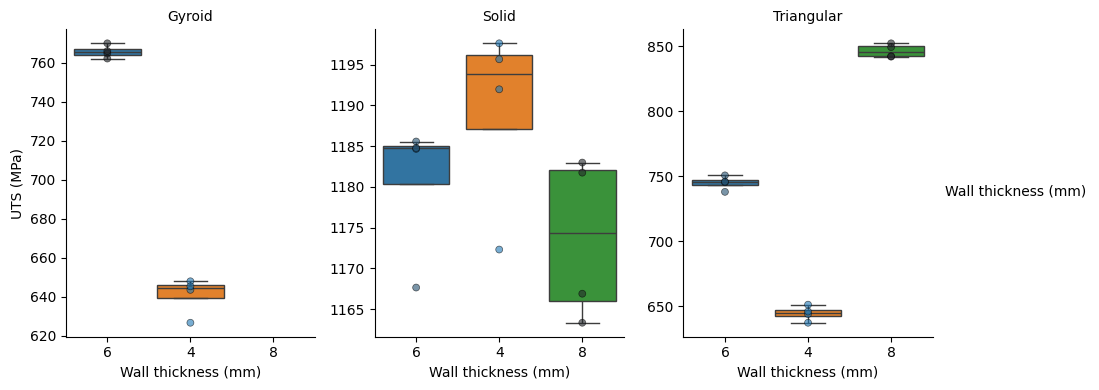

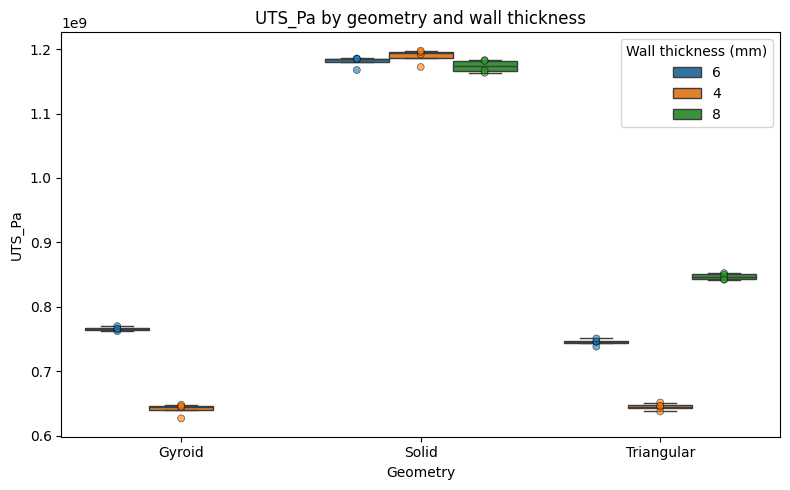

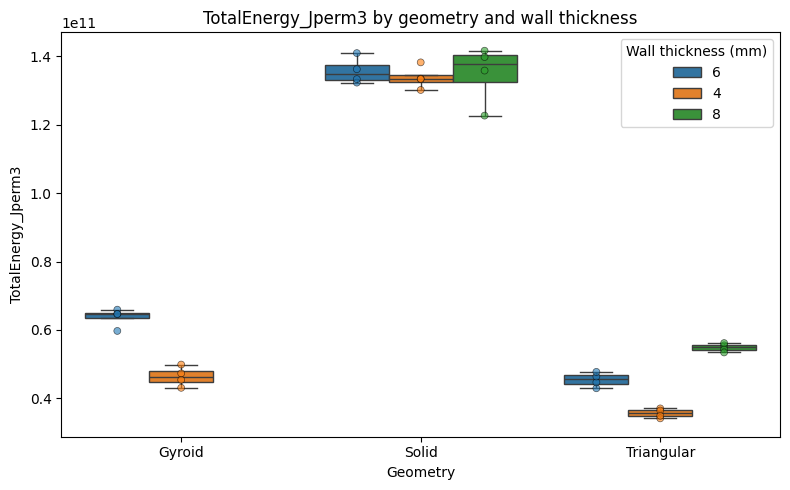

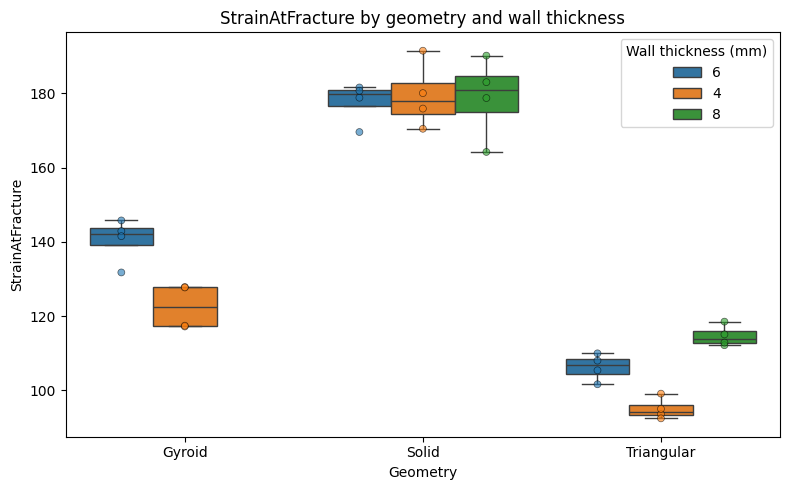

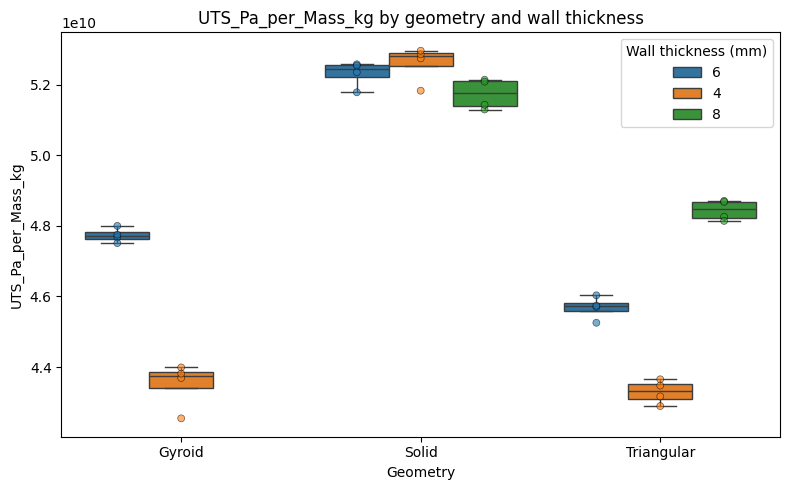

In [10]:
#Goal 1 - visulization

folder_names = [ "Gyroid_6", "Gyroid_4", "Solid_8", "Solid_6", "Solid_4", "Triangular_8", "Triangular_6", "Triangular_4"]
# folder_names = [ "Gyroid_6", "Gyroid_4", "Solid_6", "Solid_4", "Triangular_6", "Triangular_4"]
folder_addendum = ".is_tens_RawData"
parent_dir = "3DPrint"
folder_names_final = [os.path.join(parent_dir, name + folder_addendum) for name in folder_names]

#define lengths and section areas
L = 1*in_to_m #in
A = 0.125*0.25*in_to_m**2 #in^2

#
actual_length = 4.349*in_to_m
actual_area = (0.125*0.25)*in_to_m**2

#getting all the references
results_by_condition = {}

for i, folder_name in enumerate(folder_names_final):
    # print(f"dict {combo_to_measurement[folder_names[i]]}")

    reference_tests = analyze_tensile_folder(
        folder_name,
        combo_to_measurement[folder_names[i]][0]/actual_length*L, combo_to_measurement[folder_names[i]][1]/actual_area*A, combo_to_measurement[folder_names[i]][2],
        calibrate_load, calibrate_displacement
    )

    results_by_condition[folder_name] = reference_tests

metrics = [
    "UTS_Pa",              # ultimate tensile strength
    "TotalEnergy_Jperm3",  # energy absorbed
    "StrainAtFracture",     # elongation at break
    "UTS_Pa_per_Mass_kg",  #ultimate tensile strength (pa) divided by mass of peice (in kg)
]

#UTS
df = build_two_way_df(results_by_condition, "UTS_Pa")
df_plot = df.copy()
df_plot["UTS_MPa"] = df_plot["UTS_Pa"] / 1e6
df_plot["level"] = df_plot["level"].astype(str)

g = sns.catplot(
    data=df_plot,
    x="level", y="UTS_MPa",
    col="geometry",
    kind="box",
    hue="level",
    dodge=False,
    sharey=False,           # <- key change
    height=4, aspect=0.8,
    showfliers=False,  # hide the hollow-outlier markers

)

g.map_dataframe(
    sns.stripplot,
    x="level", y="UTS_MPa",
    hue="level",
    dodge=False,
    alpha=0.6, linewidth=0.5, edgecolor="k",
    jitter=False,        # <- this is the key

)

# fix double legends
for ax in g.axes.flatten():
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend_.remove()

g.add_legend(title="Wall thickness (mm)")
g.set_axis_labels("Wall thickness (mm)", "UTS (MPa)")
g.set_titles("{col_name}")
plt.show()



for metric in metrics: 
    df = build_two_way_df(results_by_condition, metric)

    # Make thickness a categorical label so legend looks nice
    df_plot = df.copy()
    df_plot["level"] = df_plot["level"].astype(str)   # "4", "6", "8", ...

    plt.figure(figsize=(8, 5))
    ax = plt.gca()

    # Boxplots: geometry on x, staggered by level
    sns.boxplot(
        data=df_plot,
        x="geometry",
        y=metric,
        hue="level",
        ax=ax,
        dodge=True,
        showfliers=False,  # hide the hollow-outlier markers

    )

    # Overlay individual points
    sns.stripplot(
        data=df_plot,
        x="geometry",
        y=metric,
        hue="level",
        dodge=True,
        ax=ax,
        alpha=0.6,
        linewidth=0.5,
        edgecolor="k",
        jitter=False,        # <- this is the key

    )

    # Fix double legend (box + strip)
    handles, labels = ax.get_legend_handles_labels()
    # number of unique levels:
    n_levels = df_plot["level"].nunique()
    ax.legend(handles[:n_levels], labels[:n_levels], title="Wall thickness (mm)")

    ax.set_xlabel("Geometry")
    ax.set_ylabel(metric)
    ax.set_title(f"{metric} by geometry and wall thickness")

    plt.tight_layout()
    plt.show()

       Time  Extension         Load
1     0.000    0.00000      3.47343
2     0.100    0.00456      4.32416
3     0.200    0.01381     10.19229
4     0.300    0.02301     57.88463
5     0.400    0.03223    138.46074
..      ...        ...          ...
511  50.572    4.21466  20361.54297
512  50.574    4.21489  19005.10938
513  50.576    4.21511  17587.25586
514  50.578    4.21532  16151.84570
515  50.580    4.21557  14723.18164

[515 rows x 3 columns]
       Time  Extension         Load
1     0.000    0.00000     39.61577
2     0.100    0.00428     39.44108
3     0.200    0.01358     45.92258
4     0.300    0.02291    121.67086
5     0.400    0.03218    232.67726
..      ...        ...          ...
591  58.536    4.87829  20049.78125
592  58.538    4.87851  18733.70508
593  58.540    4.87874  17351.25586
594  58.542    4.87897  15942.98633
595  58.544    4.87922  14539.67871

[595 rows x 3 columns]
       Time  Extension         Load
1     0.000    0.00000      4.78062
2     0.100    0

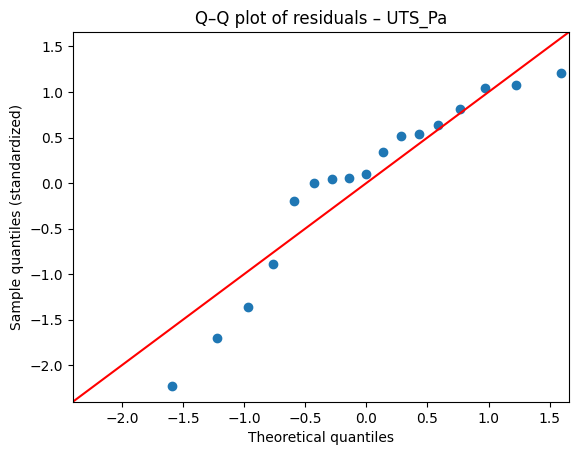

Levene’s test across groups: stat=1.5064, p=0.2594

Tukey HSD for UTS_Pa
                                  Multiple Comparison of Means - Tukey HSD, FWER=0.05                                  
             group1                          group2                meandiff   p-adj      lower         upper     reject
-----------------------------------------------------------------------------------------------------------------------
 ./Reference Tests/Reference_T1 3DPrint/Solid_4.is_tens_RawData 26040650.4925 0.0026  9305504.9939 42775795.9912   True
 ./Reference Tests/Reference_T1 3DPrint/Solid_6.is_tens_RawData 17313864.5585 0.0417   578719.0599 34049010.0572   True
 ./Reference Tests/Reference_T1 3DPrint/Solid_8.is_tens_RawData 10393594.4065 0.3067 -6341551.0921 27128739.9051  False
3DPrint/Solid_4.is_tens_RawData 3DPrint/Solid_6.is_tens_RawData  -8726785.934 0.4916 -26367178.184   8913606.316  False
3DPrint/Solid_4.is_tens_RawData 3DPrint/Solid_8.is_tens_RawData -15647056.086 0.0894 -3

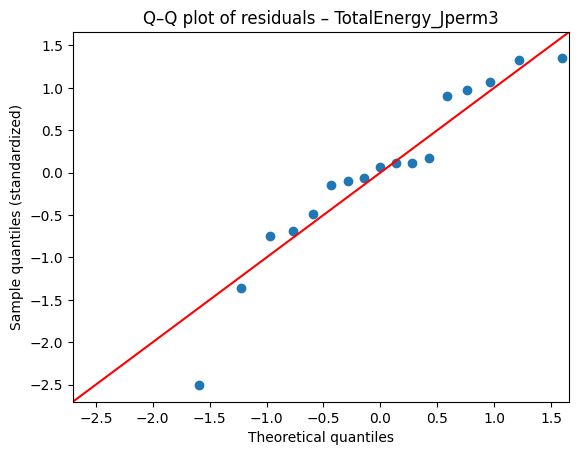

Levene’s test across groups: stat=0.6828, p=0.5782

Tukey HSD for TotalEnergy_Jperm3
                                        Multiple Comparison of Means - Tukey HSD, FWER=0.05                                        
             group1                          group2                  meandiff     p-adj        lower             upper       reject
-----------------------------------------------------------------------------------------------------------------------------------
 ./Reference Tests/Reference_T1 3DPrint/Solid_4.is_tens_RawData  -33289558676.113    0.0 -44019738804.4967 -22559378547.7294   True
 ./Reference Tests/Reference_T1 3DPrint/Solid_6.is_tens_RawData -31385678895.6115    0.0 -42115859023.9952 -20655498767.2278   True
 ./Reference Tests/Reference_T1 3DPrint/Solid_8.is_tens_RawData -32109266623.2177    0.0 -42839446751.6014  -21379086494.834   True
3DPrint/Solid_4.is_tens_RawData 3DPrint/Solid_6.is_tens_RawData   1903879780.5015  0.959  -9406723189.3552  13214482750.358

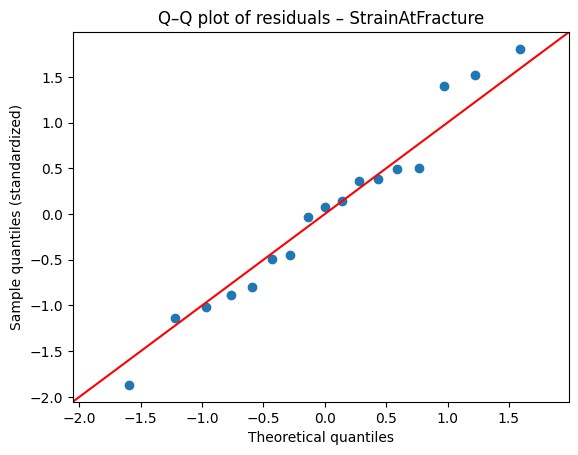

Levene’s test across groups: stat=0.3064, p=0.8203

Tukey HSD for StrainAtFracture
                          Multiple Comparison of Means - Tukey HSD, FWER=0.05                           
             group1                          group2             meandiff p-adj   lower    upper   reject
--------------------------------------------------------------------------------------------------------
 ./Reference Tests/Reference_T1 3DPrint/Solid_4.is_tens_RawData -58.0019    0.0 -75.3215 -40.6823   True
 ./Reference Tests/Reference_T1 3DPrint/Solid_6.is_tens_RawData -59.8017    0.0 -77.1213 -42.4821   True
 ./Reference Tests/Reference_T1 3DPrint/Solid_8.is_tens_RawData -58.4437    0.0 -75.7634 -41.1241   True
3DPrint/Solid_4.is_tens_RawData 3DPrint/Solid_6.is_tens_RawData  -1.7998 0.9912 -20.0562  16.4567  False
3DPrint/Solid_4.is_tens_RawData 3DPrint/Solid_8.is_tens_RawData  -0.4418 0.9999 -18.6983  17.8146  False
3DPrint/Solid_6.is_tens_RawData 3DPrint/Solid_8.is_tens_RawData   1.3579 0.99

In [11]:
#Goal 4 - One Way ANOVA - 

#get relevant folers
folder_names = [ "Solid_8", "Solid_6", "Solid_4"]
folder_addendum = ".is_tens_RawData"
parent_dir = "3DPrint"
folder_names_final = [os.path.join(parent_dir, name + folder_addendum) for name in folder_names] 
folder_names_final = folder_names_final + ["./Reference Tests/Reference_T1"]

#define lengths and section areas
L = 1*in_to_m #in
A = 0.125*0.25*in_to_m**2 #in^2

actual_length = 4.349*in_to_m
actual_area = (0.125*0.25)*in_to_m**2

#getting all the references
results_by_condition = {}

#mass array 
#directly from raw data and calculated manually
#WJ3, WJ4, #WJ5, #WJ6, WJ1new
WJ_masses = [23.262, 23.26, 23.26, 23.24, 23.268]

for i, folder_name in enumerate(folder_names_final):

    #use specific dimensions
    if not "Reference" in folder_name: 
        reference_tests = analyze_tensile_folder(
            folder_name,
            combo_to_measurement[folder_names[i]][0]/actual_length*L, combo_to_measurement[folder_names[i]][1]/actual_area*A, combo_to_measurement[folder_names[i]][2],
            calibrate_load, calibrate_displacement
        )
    #USE CAD DIMENSIONS (for waterjet parts)
    else:
        reference_tests = analyze_tensile_folder(
            folder_name,
            [L]*len(WJ_masses), [A]*len(WJ_masses), WJ_masses,
            calibrate_load, calibrate_displacement)
        
    results_by_condition[folder_name] = reference_tests

print(results_by_condition)
#define metrics
metrics = [
    "UTS_Pa",              # ultimate tensile strength
    "TotalEnergy_Jperm3",  # energy absorbed
    "StrainAtFracture"     # elongation at break
]

#ANOVA
# ----- build long DF -----
for metric_col in metrics:
    df_long = build_oneway_df(results_by_condition, metric_col)

    # ----- fit OLS for one-way ANOVA -----
    model = smf.ols(f"{metric_col} ~ C(condition)", data=df_long).fit()

    print(f"\n=== One-way ANOVA for {metric_col} ===")
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(anova_table)

    # ----- residuals -----
    resid = np.asarray(model.resid).ravel()

    # Shapiro–Wilk on residuals
    W, p_shap = shapiro(resid)
    print(f"\nShapiro–Wilk on residuals: W={W:.4f}, p={p_shap:.4g}")

    # Q–Q plot of *standardized* residuals
    resid_std = (resid - resid.mean()) / resid.std(ddof=1)
    sm.qqplot(resid_std, dist=stats.norm, line="45")
    plt.title(f"Q–Q plot of residuals – {metric_col}")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Sample quantiles (standardized)")
    plt.show()

    # Levene’s test for equal variances across groups
    groups = df_long.groupby("condition")[metric_col].apply(list)
    stat_lev, p_lev = levene(*groups)
    print(f"Levene’s test across groups: stat={stat_lev:.4f}, p={p_lev:.4g}")

    tukey = pairwise_tukeyhsd(
        endog=df_long[metric_col],
        groups=df_long["condition"],
        alpha=0.05
    )
    print(f"\nTukey HSD for {metric_col}")
    print(tukey.summary())



In [12]:
#Goal 5
from scipy.stats import t

def mean_confidence_interval(sample, confidence=0.95):
    """
    Two-sided CI for a population mean based on a sample.
    
    sample: 1D array-like of numbers
    confidence: e.g. 0.95 for 95% CI
    """
    x = np.asarray(sample, dtype=float)
    x = x[~np.isnan(x)]          # drop NaNs if any
    n = len(x)
    if n < 2:
        raise ValueError("Need at least 2 points for a CI")

    mean = x.mean()
    s = x.std(ddof=1)            # sample standard deviation
    se = s / np.sqrt(n)          # standard error

    dof = n - 1
    t_crit = t.ppf((1 + confidence) / 2, dof)  # two-sided
    margin = t_crit * se

    ci_low  = mean - margin
    ci_high = mean + margin
    return mean, ci_low, ci_high

WJ_path = "./Reference Tests/Reference_T1"
WJ_masses = [23.262, 23.26, 23.26, 23.24, 23.268]

reference_tests = analyze_tensile_folder(
    WJ_path,
    [L]*len(WJ_masses), [A]*len(WJ_masses), WJ_masses,
    calibrate_load, calibrate_displacement)
    
print(reference_tests)
data = reference_tests["UTS_Pa"]
mean, ci_low, ci_high = mean_confidence_interval(data, confidence=0.95)
print(f"mean = {mean:.3f}, 95% CI = [{ci_low:.3f}, {ci_high:.3f}]")





       Time  Extension         Load
1     0.000    0.00000      2.46954
2     0.100    0.00403      4.91734
3     0.200    0.01346     88.88831
4     0.300    0.02311    184.77623
5     0.400    0.03238    305.11151
..      ...        ...          ...
739  73.342    6.11218  10917.00684
740  73.344    6.11238  10172.36230
741  73.346    6.11258   9401.66895
742  73.348    6.11278   8625.38672
743  73.350    6.11298   7852.75635

[743 rows x 3 columns]
       Time  Extension         Load
1     0.000   -0.04256      1.60519
2     0.100   -0.03807      1.36151
3     0.200   -0.02903     12.88276
4     0.300   -0.01960    149.19690
5     0.400   -0.01041    256.47833
..      ...        ...          ...
717  71.062    5.87952  11136.10156
718  71.064    5.87972  10348.32031
719  71.066    5.87992   9540.51465
720  71.068    5.88010   8732.13672
721  71.070    5.88030   7930.69141

[721 rows x 3 columns]
       Time  Extension         Load
1     0.000    0.00000      3.87223
2     0.100    0

#GOAL 1
